```
Name: Andrea Fox
Date: July 2, 2020
Section: DSC550-T301
Assignment: Week 4 Exercises - Clustering
```

# 1 - Expectation Maximization Clustering

```
Write a script that implements the Expectation-Maximization (EM) algorithm for clustering (see Algorithm 13.3 in Chapter 13). Run the code on the iris.txt dataset. Use the first four attributes for clustering, and use the labels only for the purity-based clustering evaluation (see below). In your implementation, you should estimate the full covariance matrix for each cluster.

For EM initialization, use the first n/k points for cluster 1, the next n/k for cluster 2, and so on. For convergence testing, you can compare the sum of the euclidean distance between the old means and the new means over the k clusters. If this distance is less than ϵ=0.001 you can stop the method.

Your program output should consist of the following information:

* The final mean for each cluster
* The final covariance matrix for each cluster
* Number of iterations the EM algorithm took to converge.
* Final cluster assignment of all the points, where each point will be assigned to the cluster that yields the highest probability P(Ci|xj)
* Final size of each cluster

Finally, you must compute the 'purity score' for your clustering, computed as follows: Assume that Ci denotes the set of points assigned to cluster i by the EM algorithm, and let Ti denote the true assignments of the points based on the last attribute. Purity score is defined as:

Purity=1n∑i=1kmaxkj=1{Ci∩Tj}
```

In [5]:
#Used this for reference https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
#Also worked with Sam on this. I kept running into a problem with cluster_assignments

from sklearn.mixture import GaussianMixture
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", None, "display.max_columns", None)

#Function to take cluster assignments and truth label objects, create confusion matrix, and return purity
#Reference https://datatofish.com/confusion-matrix-python/
def compute_purity(cluster_assignments, labels):
    confusion_df = pd.DataFrame({'Predicted': cluster_assignments, 'Actual': labels})
    confusion_matrix = pd.crosstab(confusion_df['Predicted'],confusion_df['Actual'],
                                   rownames = ['Predicted'], colnames = ['Actual'])
    #Purity variable, which looks at sum of maxes of cluster assignments and divides by number of points
    purity = np.sum(confusion_matrix.max(axis = 1)) / df.shape[0]
    return purity
#Loading in the iris data
df = pd.read_csv('iris.txt', header = None, names = [1,2,3,4,'Label'])
df_noLabel = df.drop('Label', axis = 1)
labels = df['Label']

#Establishing number of clusters
k = len(labels.unique())

#Threshold given in problem
eps = 0.001

#Fitting the model with sklearn
gmm = GaussianMixture(n_components = k, tol = eps)
gmm.fit(df_noLabel)

#Get predictions
cluster_assignments = gmm.predict(df_noLabel)
df_noLabel['Cluster Assignments'] = cluster_assignments

#Print the results
for cluster in range(k):
    print('Cluster {}'.format(cluster+1))
    print('Size {}'.format(len(df_noLabel[df_noLabel['Cluster Assignments']==cluster])))
    print('Mean {}'.format(gmm.means_[cluster]))
    print('Covariance Matrix:')
    for row in gmm.covariances_[0]:
        print(row)
    print('')
    
print('Iterations to Converge: {}'.format(gmm.n_iter_))
print('Cluster assignments')
print('Purity: {}'.format(compute_purity(cluster_assignments, labels)))
print(df_noLabel)


Cluster 1
Size 50
Mean [5.006 3.418 1.464 0.244]
Covariance Matrix:
[0.121765 0.098292 0.015816 0.010336]
[0.098292 0.142277 0.011448 0.011208]
[0.015816 0.011448 0.029505 0.005584]
[0.010336 0.011208 0.005584 0.011265]

Cluster 2
Size 55
Mean [6.54639415 2.94946365 5.48364578 1.98726565]
Covariance Matrix:
[0.121765 0.098292 0.015816 0.010336]
[0.098292 0.142277 0.011448 0.011208]
[0.015816 0.011448 0.029505 0.005584]
[0.010336 0.011208 0.005584 0.011265]

Cluster 3
Size 45
Mean [5.9170732  2.77804839 4.20540364 1.29848217]
Covariance Matrix:
[0.121765 0.098292 0.015816 0.010336]
[0.098292 0.142277 0.011448 0.011208]
[0.015816 0.011448 0.029505 0.005584]
[0.010336 0.011208 0.005584 0.011265]

Iterations to Converge: 17
Cluster assignments
Purity: 0.9666666666666667
       1    2    3    4  Cluster Assignments
0    5.9  3.0  4.2  1.5                    2
1    6.9  3.1  4.9  1.5                    2
2    6.6  2.9  4.6  1.3                    2
3    4.6  3.2  1.4  0.2                    

# 2 - Density Based Clustering: DENCLUE

```
Write a script to implement the DENCLUE density-based clustering algorithm Algorithm 15.2 in chapter 15. The script should take as input a dataset D, the minimum density ξ, the tolerance for convergence ϵ, and the width h. Do not make any assumptions about the data (i.e., column names, etc), except that the last column gives the "true" cluster id.

Run your script on the iris.txt dataset, with ϵ=0.0001. Your script should output the following:

The number of clusters, and the size of each cluster.
The density attractor, followed by the set of point in that cluster.
Purity of the clustering, based on the true id.
For Iris, you should use a value of ξ that gives you 3 clusters in the end, i.e., try different values and then finally report only the results for the value that gives you 3 clusters, since there are 3 true clusters in the data. Select the value of h empirically.

To speed up the computation for estimating the density at a point, you may want to first identify the K nearest neighbors, and use only those neighbors.
```

In [26]:
!pip install networkx==1.11
#Vilius messaged our Tuesday group and told us we had to update version of networkx to make it work

In [52]:
#Referenced https://github.com/nanzai9996/kernel_trick-and_denclue_and_decison_tree-/blob/master/denclue.py for the majority of this
#Referenced https://github.com/mgarrett57/DENCLUE/blob/master/denclue.py
#Also got some help from Torrey on the networkx install update and purity score

import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
import networkx as nx
import pandas as pd
from scipy.spatial import distance
#Function climbs the "hill" of kernel density function and finds "peak", which represents the density attractor
def _hill_climb(x_t, X, W=None, h=0.36, eps=0.0001):
    error = 99.
    prob = 0.
    x_l1 = np.copy(x_t)   #X(t+1)
    radius_new = 0.
    radius_old = 0.
    radius_twiceold = 0.
    iters = 0.
    while True:
        radius_thriceold = radius_twiceold
        radius_twiceold = radius_old
        radius_old = radius_new
        x_l0 = np.copy(x_l1)       #X(t)
        x_l1, density = _step(x_l0, X, W=W, h=h)
        error = density - prob
        prob = density
        radius_new = np.linalg.norm(x_l1 - x_l0)
        radius = radius_thriceold + radius_twiceold + radius_old + radius_new
        iters += 1
        if iters > 3 and error < eps:
            break
    return [x_l1, prob, radius]

def _step(x_l0, X, W=None, h=0.36):
    n = X.shape[0]
    d = X.shape[1]
    superweight = 0.  # superweight is the kernel X weight for each item
    x_l1 = np.zeros((1, d))
    if W is None:
        W = np.ones((n, 1))
    else:
        W = W
    for j in range(n):
        kernel = kernelize(x_l0, X[j], h, d)
        kernel = kernel * W[j] / (h ** d)
        superweight = superweight + kernel
        x_l1 = x_l1 + (kernel * X[j])
    x_l1 = x_l1 / superweight
    density = superweight / np.sum(W)
    return [x_l1, density]

def kernelize(x, y, h, degree):
    kernel = np.exp(-(np.linalg.norm(x - y) / h) ** 2. / 2.) / ((2. * np.pi) ** (degree / 2))
    return kernel


#Performs DENCLUE clustering from vector arrayusing h, eps, min_density, metric
#References Hinneburg A., Gabriel HH. "DENCLUE 2.0: Fast Clustering Based on Kernel, Density Estimation". In: R. Berthold M., Shawe-Taylor J., Lavrač N. (eds), and Advances in Intelligent Data Analysis VII. IDA 2007
class DENCLUE(BaseEstimator, ClusterMixin):
    def __init__(self, h=None, eps=1e-8, min_density=0., metric='euclidean'):
        self.h = h
        self.eps = eps
        self.min_density = min_density
        self.metric = metric

    def classify(self, X, y=None, sample_weight=None):
        if not self.eps > 0.0:
            raise ValueError("eps must be positive.")
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        density_attractors = np.zeros((self.n_samples, self.n_features))
        radii = np.zeros((self.n_samples, 1))
        density = np.zeros((self.n_samples, 1))

        #Creates default values
        if self.h is None:
            self.h = np.std(X) / 5
        if sample_weight is None:
            sample_weight = np.ones((self.n_samples, 1))
        else:
            sample_weight = sample_weight
        #Initalize all labels to noise
        labels = -np.ones(X.shape[0])
        #Climb each hill
        for i in range(self.n_samples):
            density_attractors[i], density[i], radii[i] = _hill_climb(X[i], X, W=sample_weight,
                                                                      h=self.h, eps=self.eps)
        #Initialize cluster graph to finalize clusters
        cluster_info = {}
        num_clusters = 0
        cluster_info[num_clusters] = {'instances': [0],
                                      'centroid': np.atleast_2d(density_attractors[0])}
        g_clusters = nx.Graph()
        for j1 in range(self.n_samples):
            g_clusters.add_node(j1, attr_dict={'attractor':density_attractors[j1], 'radius':radii[j1],
                                'density':density[j1]})
        #Populate cluster graph
        for j1 in range(self.n_samples):
            for j2 in (x for x in range(self.n_samples) if x != j1):
                if g_clusters.has_edge(j1, j2):
                    continue
                diff = np.linalg.norm(g_clusters.node[j1]['attractor'] - g_clusters.node[j2]['attractor'])
                if diff <= (g_clusters.node[j1]['radius'] + g_clusters.node[j1]['radius']):
                    g_clusters.add_edge(j1, j2)
        #Connected components represent a cluster
        clusters = list(nx.connected_component_subgraphs(g_clusters))
        num_clusters = 0
        #Loop through all connected components
        for clust in clusters:
            #Get maximum density of attractors and location
            max_instance = max(clust, key=lambda x: clust.node[x]['density'])
            max_density = clust.node[max_instance]['density']
            max_centroid = clust.node[max_instance]['attractor']
            complete = False
            c_size = len(clust.nodes())
            if clust.number_of_edges() == (c_size * (c_size - 1)) / 2.:
                complete = True
            #Populate cluster_info dict
            cluster_info[num_clusters] = {'instances': clust.nodes(),
                                          'size': c_size,
                                          'centroid': max_centroid,
                                          'density': max_density,
                                          'complete': complete}
            #If the cluster density is not higher than the minimum
            if max_density >= self.min_density:
                labels[clust.nodes()] = num_clusters
            num_clusters += 1
        self.clust_info_ = cluster_info
        self.labels_ = labels
        return self
#Function to return purity of clusters 
def purity_true_id(true_id, instances):
    # Get n from instances argument
    n = 0
    for points in instances:
        n += len(points)
       
    temp_sum = 0 # Running sum for calculation
   
    # Iterate through instances to find the max intersection between true id and instances
    for cluster in range(len(instances)):
        max_cluster = 0
        for i in range(len(true_id)):
            max_check = len(list(set(instances[cluster]).intersection(true_id[i])))
            if max_check > max_cluster:
                max_cluster = max_check
        temp_sum += max_cluster
   
    # Divide sum of max intersetions by n
    purity = temp_sum / n
   
    return purity
#Loading in data and setting variables needed
iris = pd.read_csv('iris.txt', header = None)
data = iris[[0,1,2,3,4]].values
samples = np.mat(data[:,0:4])
true_labels=data[:,-1]
labels = list(set(true_labels))
true_id = np.zeros((3, 50))
index = range(len(true_labels))
for i in range(len(labels)):
    true_id[i]=[j for j in index if true_labels[j]==labels[i]]
d = DENCLUE(0.36, .0001, .13)
d.classify(samples)
results = d.clust_info_
# Add cluster classifications to pandas df
iris = iris.rename(columns = {0:1, 1:2, 2:3, 3:4, 4:'Labels'})
iris['Cluster'] = ""
for cluster in range(len(results)):
    for point in results[cluster]['instances']:
                  iris['Cluster'][point] = cluster
            
# Create instances array to compare to True ID
instances = []
for cluster in range(len(results)):
    instances.append(results[cluster]['instances'])
#Printing out final results
print('Final Number of Clusters: {}'.format(len(results)))
print('Purity: {} \n'.format(purity_true_id(true_id, instances)))
for cluster in range(len(results)):
    print('Cluster: {}'.format(cluster))
    print('Size of Cluster: {}'.format(results[cluster]['size']))
    print('Density Attractor: {}'.format(results[cluster]['centroid']))
    print('Points in Each Cluster: \n {} \n'.format(iris[iris['Cluster']==cluster]))

Final Number of Clusters: 3
Purity: 0.88 

Cluster: 0
Size of Cluster: 68
Density Attractor: [6.18843436 2.89824105 4.71897548 1.56280594]
Points in Each Cluster: 
        1    2    3    4           Labels Cluster
0    5.9  3.0  4.2  1.5  Iris-versicolor       0
1    6.9  3.1  4.9  1.5  Iris-versicolor       0
2    6.6  2.9  4.6  1.3  Iris-versicolor       0
4    6.0  2.2  4.0  1.0  Iris-versicolor       0
7    5.8  2.7  5.1  1.9   Iris-virginica       0
..   ...  ...  ...  ...              ...     ...
139  5.5  2.4  3.8  1.1  Iris-versicolor       0
142  6.2  2.9  4.3  1.3  Iris-versicolor       0
143  6.5  2.8  4.6  1.5  Iris-versicolor       0
144  6.0  3.0  4.8  1.8   Iris-virginica       0
146  5.5  2.6  4.4  1.2  Iris-versicolor       0

[68 rows x 6 columns] 

Cluster: 1
Size of Cluster: 50
Density Attractor: [4.9747532  3.35428642 1.47776422 0.23667237]
Points in Each Cluster: 
        1    2    3    4       Labels Cluster
3    4.6  3.2  1.4  0.2  Iris-setosa       1
5    4.7  

C:\Users\Andrea\OneDrive\Anaconda3\lib\site-packages\ipykernel_launcher.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 3 - Clustering

```
The data for this portion of the assignment will be the Iris flower dataset. The dataset consists of 50 samples from each of three species of Iris, with four features measured from each sample.scikit-learn provides a function to load the dataset (no download required).

The Idea: Choosing k for k-means

Your objective here will be to assess the performance of k-means clustering on the Iris dataset. Recall that the number of clusters, k, is an input parameter to the k-means algorithm. A variety of measurements are available for estimating the optimal value of k. For this assignment, you will look at the sum of squared deviation (SSQ) and the gap statistic. Both of these criteria make use of the intuition that k-means tries to minimize variance (the distance or deviation of each point from each of the k clusters) by iteratively assigning points to their nearest clusters.

Choosing k with SSQ

The SSQ criterion is a direct application of the intuition that k-means tries to minimize variance. Recall that the SSQ criterion sweeps over a range of possible k values, with each value of k associated with a degree of deviation (the distance of each point from each of the k clusters). These deviations can be squared and summed to arrive at the “sum of squared deviation” (SSQ) for each value of k. Larger values of k are expected to continue to reduce the SSQ (because there are more clusters for points to be near, reducing their deviation). However, one could expect a leveling-off in the SSQ once the value of k exceeds the true number of clusters, as this would result in true clusters (that is, clusters actually present in the data) being separated. If, then, one plots the SSQ over a range of k values, this leveling-off point may produce a noticeable “elbow” in the plot. By this criterion, the estimated optimal value of k is that which occurs at this elbow point. While simple, the difficulty with this criterion is that often the elbow point is not distinctive or well-defined.

What to Provide

Your output should contain the following:

* The SSQs computed fork values between 1 and 10 (inclusive). There should be one plot corresponding to the SSQs.
* The gap statistics computed fork values between 1 and 10 (inclusive). There should be two plots corresponding to the gap statistics.

Given this output, respond to the following questions:
```

#### 1 - SSQ

Clusters and with SSE Values
----------------------------------------
Clusters: 1 	SSE: 681.3706
Clusters: 2 	SSE: 152.3479517603579
Clusters: 3 	SSE: 81.70628013582343
Clusters: 4 	SSE: 59.34876557610241
Clusters: 5 	SSE: 46.98506112266112
Clusters: 6 	SSE: 39.57886631746632
Clusters: 7 	SSE: 35.25750383733913
Clusters: 8 	SSE: 31.539437170672464
Clusters: 9 	SSE: 29.295542939903235
Clusters: 10 	SSE: 27.213400082760376


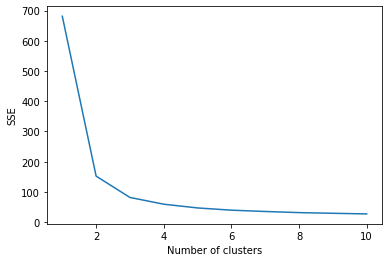

In [1]:
#Referenced https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion for most of the coding specifics. Also created functions to make nicer and after seeing Torrey's example
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#Function to perform kmeans using data and number of clusters
def sse_form(data, n):
    sse = {}
    for k in range(1, n+1):
        kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(data)
        data["clusters"] = kmeans.labels_
        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_
    return(sse)

#Function to print results of clusters and SSE values 
def sse_pretty(sse_values):
    print('Clusters and with SSE Values')
    print('-'*40)
    for k,v in sse_values.items():
        print('Clusters: {} \tSSE: {}'.format(k,v))

#Function to do the plot for elbow
def elbow_plt(sse):
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

#Main function.  
def main():
    try:
        #Loading Iris dataset from sklearn datasets
        iris = load_iris()
        df = pd.DataFrame(iris.data, columns=iris['feature_names'])
        k = 10 
        #Pulling in other functions
        sse_values = sse_form(df, k)
        sse_pretty(sse_values)
        elbow_plt(sse_values)
    #Exception handling    
    except Exception as exception:
        print('exception')
        # print the traceback of the exception
        traceback.print_exc()
        # list name of exception and any arguments
        print('An exception of type {0} occurred.'.format(type(exception).__name__, exception.args)); 
main()


#### 2 - Gap Statistics

In [7]:
from sklearn.datasets import load_iris
import pandas as pd
iris = load_iris()
df = pd.DataFrame(iris.data)
data = df[[0,1,2,3]].values

C:\Users\Andrea\OneDrive\Anaconda3\lib\site-packages\scipy\cluster\vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


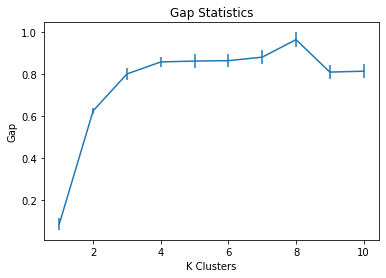

In [8]:
#Using https://github.com/hevronig/ca4ls/blob/105e2f234ea46f3e64c0a823c998eb9fecc3da4b/gap.py to compute Gap Statistics

# gap.py
# (c) 2013 Mikael Vejdemo-Johansson
# BSD License
#
# SciPy function to compute the gap statistic for evaluating k-means clustering.
# Gap statistic defined in
# Tibshirani, Walther, Hastie:
#  Estimating the number of clusters in a data set via the gap statistic
#  J. R. Statist. Soc. B (2001) 63, Part 2, pp 411-423

import scipy
import scipy.cluster.vq
import scipy.spatial.distance
import math
import numpy as np
#Found out some of scipy (log, mean, diags, sqrt) was being deprecated so had to switch to using numpy for those pieces
from numpy.lib import scimath
dst = scipy.spatial.distance.euclidean

def gap(data, refs=None, nrefs=20, ks=range(1,11)):
    """
    Compute the Gap statistic for an nxm dataset in data.
    Either give a precomputed set of reference distributions in refs as an (n,m,k) scipy array,
    or state the number k of reference distributions in nrefs for automatic generation with a
    uniformed distribution within the bounding box of data.
    Give the list of k-values for which you want to compute the statistic in ks.
    """
    shape = data.shape
    if refs==None:
        tops = data.max(axis=0)
        bots = data.min(axis=0)
        dists = scipy.matrix(np.diag(tops-bots))
        rands = scipy.random.random_sample(size=(shape[0],shape[1],nrefs))
        for i in range(nrefs):
            rands[:,:,i] = rands[:,:,i]*dists+bots
    else:
        rands = refs

    gaps = np.zeros((len(ks),))
    errors = np.zeros((len(ks),))
    labels = dict((el,[]) for el in ks)
    for (i,k) in enumerate(ks):
        (kmc,kml) = scipy.cluster.vq.kmeans2(data, k)
        disp = sum([dst(data[m,:],kmc[kml[m],:]) for m in range(shape[0])])
        labels[k] = kml

        refdisps = np.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
            (kmc,kml) = scipy.cluster.vq.kmeans2(rands[:,:,j], k)
            refdisps[j] = sum([dst(rands[m,:,j],kmc[kml[m],:]) for m in range(shape[0])])
        #Compute gaps
        gaps[i] = scimath.log(np.mean(refdisps))-scimath.log(disp)
        #Compute errors (got this part from Torrey's example)
        errors[i] = scimath.sqrt(sum(((scimath.log(refdisp)-np.mean(scimath.log(refdisps)))**2) \
                                for refdisp in refdisps)/float(nrefs)) * scimath.sqrt(1+1/nrefs)
    return gaps, labels, errors

def gap_stat_plt(gaps, errors):
    xval = range(1, len(gaps)+1)
    yval = gaps
    plt.errorbar(xval, yval, xerr= None, yerr = errors)
    plt.xlabel('K Clusters')
    plt.ylabel('Gap')
    plt.title('Gap Statistics')
    plt.show()
    
gaps, labels, errors = gap(data, refs = None, nrefs = 20, ks= range(1,11))

gap_stat_plt(gaps, errors)

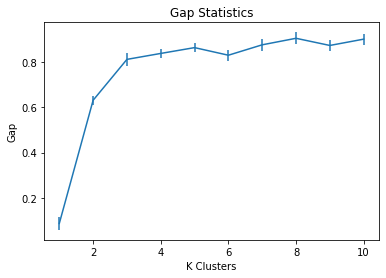

In [9]:
gaps, labels, errors = gap(data, refs = None, nrefs = 30, ks= range(1,11))

gap_stat_plt(gaps, errors)

* Where did you estimate the elbow point to be (between what values of k)? What value of k was typically estimated as optimal by the gap statistic? To adequately answer this question, consider generating both measures several times, as there may be some amount of variation in the value of k that they each estimate as optimal.

Clusters and with SSE Values
----------------------------------------
Clusters: 1 	SSE: 681.3706
Clusters: 2 	SSE: 152.3479517603579
Clusters: 3 	SSE: 81.70628013582343
Clusters: 4 	SSE: 59.34876557610241
Clusters: 5 	SSE: 46.98506112266112
Clusters: 6 	SSE: 39.57886631746632
Clusters: 7 	SSE: 35.261468473193474
Clusters: 8 	SSE: 31.667370060495067
Clusters: 9 	SSE: 29.415410353535357
Clusters: 10 	SSE: 27.333267496392494


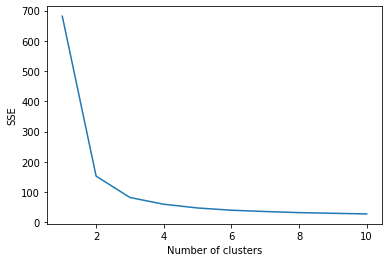

In [5]:
k = 10
sse_values = sse_form(df, k)
sse_pretty(sse_values)
elbow_plt(sse_values)

#After k=3 is when it really starts to level off

* How close are the estimates generated by the elbow point and gap statistic to the number of species of Iris represented in the dataset?

```
I think they both look fairly similar when you look at the plots, but I can definitely visualize it better looking at SSQ vs gap statistics. Data said there were 3 species of iris, which is where the bend starts leveling off.
```

* Assuming we are trying to generate one cluster for each Iris species represented in the dataset, does one measure seem to be a consistently better criterion for choosing the value of k than the other? Why or why not?

```
Since I'm not as familiar with gap statistics I went here (https://medium.com/@ODSC/unsupervised-learning-evaluating-clusters-bd47eed175ce) to look at a better definition. If I'm reading this right they're both using k-means and hierarchical. If we're going by opinion I think SSQ was easier to read and do.
```

# 4 - Complete the following in your text:

### Mining Massive Datasets Page 252 --- Exercise 7.2.2

#### How would the clustering of Example 7.2 change if we used for the distance between two clusters:

* (a) The minimum of the distances between any two points, one from each cluster

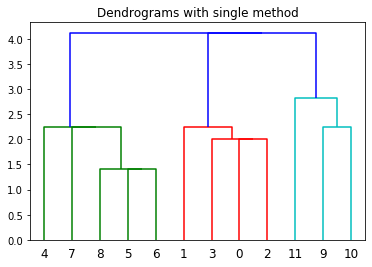

In [42]:
#Referenced https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html for dendrogram
#Referenced https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html for agglomerative hierarchy
#Also referenced Torrey during our Tuesday call. 
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

def dendrogram(d, method):
    plt.title("Dendrograms with {} method".format(method))
    den = hierarchy.dendrogram(hierarchy.linkage(d, method = method))
    
def hier_cluster(n, method, d):
    cluster = AgglomerativeClustering(n_clusters = n, affinity = 'euclidean', linkage = method)
    cluster.fit_predict(d)
    plt.scatter(points[:,0], points[:,1], c = cluster.labels_, cmap= 'rainbow')
    plt.title("Hierarchical clustering with {} method".format(method))
    
dendrogram(points, 'single')

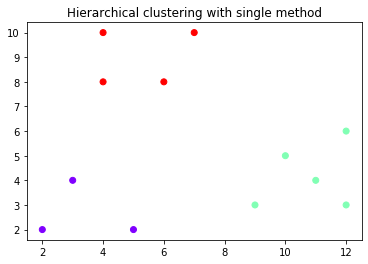

In [43]:
cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
hier_cluster(3, 'single', points)

* (b) The average of the distances between pairs of points, one from each of the two clusters

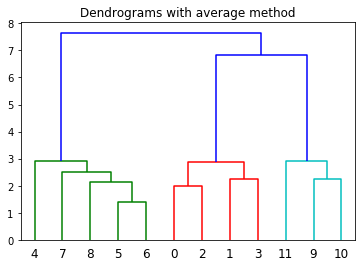

In [40]:
dendrogram(points, 'average')

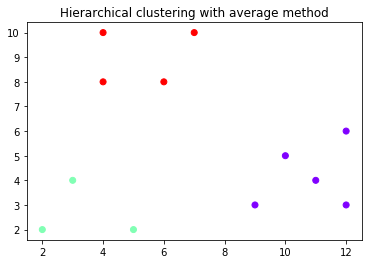

In [41]:
hier_cluster(3, 'average', points)

### Mining Massive Datasets Page 260 --- Exercise 7.3.4

##### For the three clusters of Fig. 7.8:

In [21]:
import numpy as np
#Creating arrays for the clusters. I'm basing the cluster off of the visual from the book.
c1 = np.array([[4,10], [7,10], [4,8], [6,8]])
c2 = np.array([[3,4], [2,2], [5,2]])
c3 = np.array([[10,5], [12,6], [11,4], [9,3], [12,3]])

#Combining clusters
clusters = [c1, c2, c3]

* (a) Compute the representation of the cluster as in the BFR Algorithm. That is, compute N, SUM, and SUMSQ
* (b) Compute the variance and standard deviation of each cluster in each of the two dimensions

In [27]:
#Worked with Sam on this part. I had parts of it (variance and standard deviation)
for cluster in clusters:
    N = len(cluster) #N is the number of points in a cluster
    SUM = tuple(np.sum(cluster, axis = 0)) #SUM looks at the sum of x's and y's
    SUMSQ = tuple(np.sum(np.square(cluster), axis = 0)) #SUMSQ sum of the squares. Saw this a lot in Excel when I looked it up
    variance = tuple(np.divide(SUMSQ, N) - np.square((np.divide(SUM, N)))) #Variance is average of the squared differences of the mean 
    std = tuple(np.sqrt(variance)) #Standard variance is square root of variance
    print('Cluster: {}'.format(cluster))
    print('\n N: {}'.format(N))
    print('SUM: {}'.format(SUM))
    print('SUMSQ: {}'.format(SUMSQ))
    print('Variance: {}'.format(variance))
    print('Standard Deviation: {}\n'.format(std))
    

Cluster: [[ 4 10]
 [ 7 10]
 [ 4  8]
 [ 6  8]]

 N: 4
SUM: (21, 36)
SUMSQ: (117, 328)
Variance: (1.6875, 1.0)
Standard Deviation: (1.299038105676658, 1.0)

Cluster: [[3 4]
 [2 2]
 [5 2]]

 N: 3
SUM: (10, 8)
SUMSQ: (38, 24)
Variance: (1.5555555555555536, 0.8888888888888893)
Standard Deviation: (1.2472191289246464, 0.9428090415820636)

Cluster: [[10  5]
 [12  6]
 [11  4]
 [ 9  3]
 [12  3]]

 N: 5
SUM: (54, 21)
SUMSQ: (590, 95)
Variance: (1.3599999999999852, 1.3599999999999994)
Standard Deviation: (1.1661903789690538, 1.1661903789690597)



### Mining Massive Datasets Page 260 --- Exercise 7.3.5

#### Suppose a cluster of three-dimensional points has standard deviation of 2, 3, and 5, in the three dimensions, in that order. Compute the Mahalanobis distance between the orign (0,0,0) and the point (1, -3.4)

In [13]:
#Was trying to use https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html as an example. Sam helped me clear up a few things I had wrong
from scipy.spatial import distance
def mahalanobis_distance(std, point1, point2): #point1 = origin here
    dimensions = len(std)
    temp = 0
    for i in range(dimensions):
        temp += ((point1[i] - point2[i])/std[i])**2
    distance = temp**(1/2)
    return distance

point = [1,-3,4] #Originally I kept reading this as -3.4 instead of -3, 4
origin = [0,0,0] #Origin called out in question
std = [2,3,5] #Standard deviance 
mahalanobis_distance(std,origin,point)

1.374772708486752